In [9]:
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Data loading and analysis

No. of labels =  193


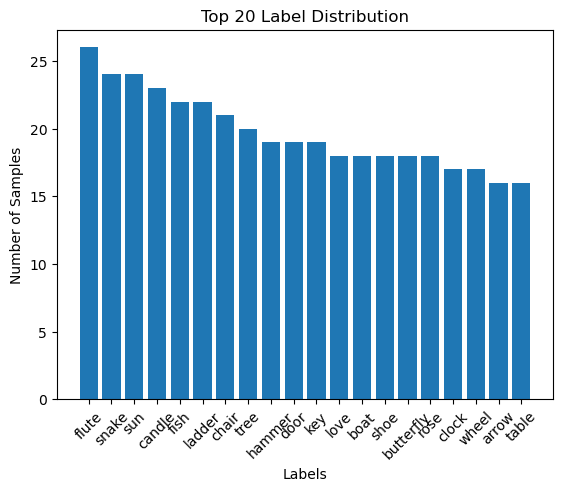

In [3]:
data = np.load("data.npy",allow_pickle=True) #load the dataset
labels = data[:, 3]                          #Get labels from the dataset

# Calculate label frequencies
unique_labels, label_counts = np.unique(labels, return_counts=True)
print('No. of labels = ',len(unique_labels))

#Sort labels based on counts and select the top 20
sorted_indices = np.argsort(label_counts)[::-1]
top_labels = unique_labels[sorted_indices][:20]
top_counts = label_counts[sorted_indices][:20]

# Plot the bar graph for top 20 labels
plt.bar(top_labels, top_counts)
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Top 20 Label Distribution')
plt.xticks(rotation=45)
plt.show()

Class of the KNN from scratch

In [15]:
class KNN:
    def __init__(self, hy_param):
        self.k = hy_param[0]
        self.distance_matrix = hy_param[2]
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        if self.distance_matrix == 'Euclidean':
            squared_diffs = (self.X_train - x)**2

            sum_squared_diffs = np.sum(squared_diffs, axis=1)

            distances = np.sqrt(sum_squared_diffs)

        elif self.distance_matrix == 'Manhattan':
            distances = [np.sum(np.abs(x - x_train)) for x_train in self.X_train]

            squared_diffs = np.abs(self.X_train - x)

            sum_squared_diffs = np.sum(squared_diffs, axis=1)

            distances = np.sqrt(sum_squared_diffs)

        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        label_counts = {}
        for label in k_nearest_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        most_common_label = max(label_counts, key=label_counts.get)

        return most_common_label

The function for KNN run and extract the results

In [17]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_size)
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    X_train = X_shuffled[:-num_test_samples]
    y_train = y_shuffled[:-num_test_samples]
    X_test = X_shuffled[-num_test_samples:]
    y_test = y_shuffled[-num_test_samples:]
    
    return X_train, X_test, y_train, y_test

def hyper_param(h_param):
    h_list = list(product(*h_param.values()))
    return h_list

def output_of_knn(predictions_p, y_test_p):
    accuracy = accuracy_score(y_test_p, predictions_p)
    precision_macro = precision_score(y_test_p, predictions_p, average='macro',zero_division=0)
    recall_macro = recall_score(y_test_p, predictions_p, average='macro',zero_division=0)
    f1_macro = f1_score(y_test_p, predictions_p, average='macro')
    return f1_macro, accuracy,precision_macro, recall_macro

def KNN_Run(h_param, test_split_ratio=0.2):
    hy_param = hyper_param(h_param)
    f_1_score = []
    accuracy = []
    precision = []
    recall = []

    dataset = np.load("data.npy",allow_pickle=True)

    for i in hy_param:
        my_knn = KNN(i)
        encoder = i[1]
        if encoder == 'RESNET':
            X = dataset[:,1]  # Load the Data
            X = np.concatenate([item.flatten() for item in X]).reshape(1500, 1024)     #for RESNETs- 1st column
            
        elif encoder == 'VIT':
            X = dataset[:,2]  # Load the Data
            X = np.concatenate([item.flatten() for item in X]).reshape(1500, 512)      #for VITs- 2nd column
            
        y_train = dataset[:,3]
        X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=test_split_ratio, random_state=42)

        my_knn.fit(X_train, y_train)
        predictions = my_knn.predict(X_test)

        f_1_score_t, accuracy_t, precision_t, recall_t = output_of_knn(predictions, y_test)
        f_1_score.append(f_1_score_t)
        accuracy.append(accuracy_t)
        precision.append(precision_t)
        recall.append(recall_t)
    return f_1_score, accuracy, precision, recall, len(hy_param)


The best accuracy for given diffrent combination of the parameters

In [18]:
def hyper_param(h_param):

    h_list = list(product(*h_param.values()))
    return h_list

h1_param = {
        'k_list' : [1,2,3,4,5,6],
        'encoder_list' : ['RESNET', 'VIT'],
        'distance_matrix_list' : ['Euclidean', 'Manhattan']
        }
f_1_score, accuracy, precision, recall, len_hy = KNN_Run(h1_param)
hy_param = hyper_param(h1_param)
max_accu = accuracy.index(max(accuracy))
print("Maximum accuracy = ", max(accuracy), "for hyperparameters (K, encoder, distance_matrix) =",hy_param[max_accu])


Maximum accuracy =  0.2866666666666667 for hyperparameters (K, encoder, distance_matrix) = (4, 'VIT', 'Euclidean')
